In [20]:
import os
import sys
from collections import defaultdict
from math import pi
import pickle
import numpy as np
from numpy import gradient
from numpy.linalg import norm
from matplotlib import pyplot as plt
from packages import data_container
from packages.data_container import Data
from packages.helper import traj_speed, beta, min_dist, d_psi, min_sep, play_trajs
# For pickle to load the Data object, which is defined in packages.data_container
sys.modules['data_container'] = data_container

In [ ]:
# d_psi(p0,p1,v0,v1)
p0

In [2]:
'''Import experiment 1 data'''

header=('subj_x', 'subj_y', 'subj_yaw')
info={'p_goal':[], 'p_obst':[], 'obst_angle':[], 'obst_speed':[], 'subj_id':[], 'trial_id':[], 'stimuli_onset':[],
      'match_onset':[], 'stimuli_out':[], 'w_goal': 0.1, 'w_obst': 0.1, 'order':[], 'ps_trial':[], 'ps_subj':[],
      'time_stamp':[], 'pass_order':[], 'p_subj':[], 'v_subj':[], 'a_subj':[], 'v_obst':[]}
data = Data(Hz=30, header=header, info=info)

file_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data\\Cohen_movObst1\\Cohen_movObst_exp1_rawData.csv'))

ii = 0
head = 0
tail = 0
# subj_ps = {}
ps = 0
with open(file_path, 'r') as f:
    trials = [line.split(',') for line in f.read().split('\n')]
head = 0
while True:
    for i in range(head+1, len(trials)):
        if trials[i][0] == '':
            tail = i - 1
            break
    i_subj = int(trials[head][1])
    i_trial = int(trials[head][3])
    time_stamp = [float(line[0])/data.Hz for line in trials[head+2:tail+1]]
    subj = np.array([[float(line[5])/100, float(line[6])/100, float(line[7])] for line in trials[head+2:tail+1]])
    goal = np.array([[float(line[1])/100, float(line[2])/100] for line in trials[head+2:tail+1]])
    obst = np.array([[float(line[3])/100, float(line[4])/100] for line in trials[head+2:tail+1]])
    onset = 0
    for i in range(len(subj)):
        if subj[i][1] >= 1:
            onset = i
            break
    obst[onset:] = np.linspace(obst[onset], obst[-1], len(obst[onset:]))
    data.add_traj(subj)
    p0 = Data.filter(subj[:,:2], time_stamp, data.Hz, 4, 0.6)
    v0 = gradient(p0, axis=0) * data.Hz
    a0 = gradient(v0, axis=0) * data.Hz
    p1 = obst

    # Use average speed at between -2 to -1 second as the trial preferred speed
    if len(subj) > 2 * data.Hz:
        ps = np.mean(traj_speed(subj[-2*data.Hz:-data.Hz,0:2], data.Hz))
    else:
        ps = 0

    # After inspection, those trials are no good
    if len(obst) < 32 or subj[-1][1] < 0:
        data.add_dump(ii, 'recording error')

    if norm(obst[-1,:] - obst[-31,:]) < 0.42:
        s_obst = 0.4
    elif norm(obst[-1,:] - obst[-31,:]) < 0.62:
        s_obst = 0.6
    elif norm(obst[-1,:] - obst[-31,:]) < 0.82:
        s_obst = 0.8
    else:
        s_obst = None

    if obst[0,1] < 4.1:
        angle = 70
    elif obst[0,1] < 4.8:
        angle = 90
    elif obst[0,1] < 5.4:
        angle = 110
    else:
        angle = None

    if obst[0,0] > 0 and angle:
        angle = -angle
        
    # Compute pass order
    for i in range(onset, len(subj) - 1):
        _beta = beta(p0[i], p1[i], v0[i])
        if abs(_beta) > pi / 2:
            stimuli_out = i
            # 1: pass in front of obst, -1: pass behind obst, 0: freewalk trial
            pass_order = np.sign(_beta * -angle)
            break
    v1 = (obst[-1] - obst[onset]) / (len(obst) - 1 - onset) * data.Hz
    v1 = np.tile(v1, (len(p1),1))
    
    # Compute the onset of matching pass order with dpsi
    match_onset = onset + 2
    if ii not in data.dump:
        dpsis = d_psi(p0, p1, v0, v1)[:stimuli_out]
        imax = np.argmax(np.absolute(dpsis))
        for i in range(imax, onset + 2, -1):
            match_onset = i
            if np.sign(dpsis[i]) != np.sign(dpsis[i-1]):
                break
        
    data.add_info({'p_goal':goal, 'p_obst':obst, 'obst_angle':angle, 'obst_speed':s_obst, 'subj_id':i_subj, 
                   'trial_id':i_trial, 'stimuli_onset':onset, 'stimuli_out':stimuli_out, 'match_onset':match_onset,
                   'ps_trial':ps, 'ps_subj':0, 'time_stamp':time_stamp, 'pass_order':pass_order,
                   'p_subj':p0, 'v_subj':v0, 'a_subj':a0, 'v_obst':v1})
    if tail + 3 >= len(trials):
        break
    head = tail + 2
    ii += 1
        
# Setting subject preferred speed to every trial
ps_subj = defaultdict(list)
for i in range(len(data.trajs)):
    subj_id = data.info['subj_id'][i]
    ps_subj[subj_id].append(data.info['ps_trial'][i])
for i in range(len(data.trajs)):
    subj_id = data.info['subj_id'][i]
    data.info['ps_subj'][i] = np.mean(ps_subj[subj_id])
    
outfile = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data\\Cohen_movObst_exp1_data.pickle'))        
with open(outfile, 'wb') as file:   
    pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)       

(array([  2.,  23.,  71., 176., 245., 285., 158.,  40.,   4.,   1.]),
 array([ 17. ,  30.4,  43.8,  57.2,  70.6,  84. ,  97.4, 110.8, 124.2,
        137.6, 151. ]),
 <a list of 10 Patch objects>)

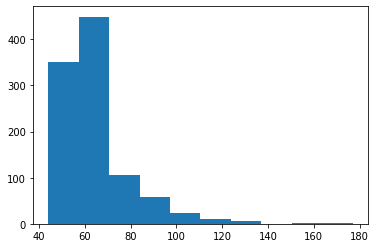

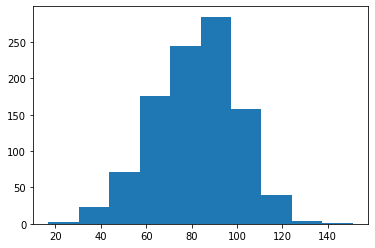

In [33]:
match_onsets = []
lens = []
for i in range(len(data.trajs)):
    if i not in data.dump:
        match_onsets.append(data.info['match_onset'][i])
        lens.append(data.info['stimuli_out'][i] - data.info['match_onset'][i])
plt.hist(match_onsets)
plt.figure()
plt.hist(lens)

In [ ]:
for i in range(len(data.trajs)):
    if i not in data.dump:
        print(np.linalg.norm(data.info['v_obst'][i][0]))

In [5]:
'''Check imported data'''
%matplotlib qt
vals = []
for i in range(len(data.trajs)):
    if i not in data.dump:
        onset = data.info['stimuli_onset'][i]
        p_subj = np.array(data.trajs[i])
        p_goal = np.array(data.info['p_goal'][i])
        p_obst = np.array(data.info['p_obst'][i])
        angle = data.info['obst_angle'][i]
        vals.append(data.info['ps_subj'][i])
        speed = traj_speed(data.info['p_subj'][i], data.Hz)
        plt.plot(speed)
#         plt.plot(vals)
        if angle == 70 or angle == -70:
#             plt.plot(p_obst[:,0], p_obst[:,1])
            plt.plot(speed)

In [14]:
'''Import experiment 2 data'''

header=('subj_x', 'subj_y', 'subj_yaw')
info={'p_goal':[], 'p_obst':[], 'obst_angle':[], 'obst_dist':[], 'obst_speed':[], 'subj_id':[], 'trial_id':[], 
      'stimuli_onset':[],'match_onset':[], 'stimuli_out':[], 'w_goal': 0.1, 'w_obst': 0.1, 'order':[], 'ps_trial':[], 
      'ps_subj':[], 'time_stamp':[], 'pass_order':[], 'p_subj':[], 'v_subj':[], 'a_subj':[], 'v_obst':[]}
exp2 = Data(Hz=30, header=header, info=info)

file_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data\\Cohen_movObst2\\Cohen_movObst_exp2_rawData.csv'))
ii = 0
head = 0
tail = 0
# subj_ps = {}
ps = 0
with open(file_path, 'r') as f:
    trials = [line.split(',') for line in f.read().split('\n')]

while True:
    for i in range(head+1, len(trials)):
        if trials[i][0] == '':
            tail = i - 1
            break
    i_subj = int(trials[head][1])
    i_trial = int(trials[head][3])
    time_stamp = [float(line[0])/exp2.Hz for line in trials[head+2:tail+1]]
    subj = np.array([[float(line[5])/100, float(line[6])/100, float(line[7])] for line in trials[head+2:tail+1]])
    goal = np.array([[float(line[1])/100, float(line[2])/100] for line in trials[head+2:tail+1]])
    obst = np.array([[float(line[3])/100, float(line[4])/100] for line in trials[head+2:tail+1]])
    onset = 0
    for i in range(len(subj)):
        if subj[i][1] >= 1:
            onset = i
            break
    obst[onset:] = np.linspace(obst[onset], obst[-1], len(obst[onset:]))
    exp2.add_traj(subj)
    p0 = Data.filter(subj[:,:2], time_stamp, exp2.Hz, 4, 0.6)
    v0 = gradient(p0, axis=0) * exp2.Hz
    a0 = gradient(v0, axis=0) * exp2.Hz
    p1 = obst

    # Use average speed at between -2 to -1 second as the trial preferred speed
    if len(subj) > 2 * exp2.Hz:
        ps = np.mean(traj_speed(subj[-2*exp2.Hz:-exp2.Hz,0:2], exp2.Hz))
    else:
        ps = 0

    # After inspection, those trials are no good
    if len(obst) < 30:
        exp2.add_dump(ii, 'recording error')
    if ii == 325 or ii == 778:
        exp2.add_dump(ii, 'abnormal speed')

    s_obst = 0.8
    if obst[0, 1] < 5:
        dist = None
    elif obst[0, 1] < 6:
        dist = 4.7
    elif obst[0, 1] < 7:
        dist = 5.8

    if obst[-9][1] - obst[-1][1] > 0.1:
        angle = 140
    elif obst[-9][1] - obst[-1][1] > 0.08:
        angle = 130
    elif obst[-9][1] - obst[-1][1] > 0.06:
        angle = 120
    elif obst[-9][1] - obst[-1][1] > 0.04:
        angle = 110
    elif obst[-9][1] - obst[-1][1] > 0.02:
        angle = 100
    else:
        angle = None
    if obst[0,0] > 0 and angle:
        angle = -angle
    
    # Compute pass order
    for i in range(onset, len(subj) - 1):
        _beta = beta(p0[i], p1[i], v0[i])
        if abs(_beta) > pi / 2:
            stimuli_out = i
            # 1: pass in front of obst, -1: pass behind obst, 0: freewalk trial
            pass_order = np.sign(_beta * -angle)
            break
    v1 = (obst[-1] - obst[onset]) / (len(obst) - 1 - onset) * exp2.Hz
    v1 = np.tile(v1, (len(p1),1))
    
    # Compute the onset of matching pass order with dpsi
    match_onset = onset + 2
    if ii not in exp2.dump:
        dpsis = d_psi(p0, p1, v0, v1)[:stimuli_out]
        imax = np.argmax(np.absolute(dpsis))
        for i in range(imax, onset + 2, -1):
            match_onset = i
            if np.sign(dpsis[i]) != np.sign(dpsis[i-1]):
                break

    exp2.add_info({'p_goal':goal, 'p_obst':obst, 'obst_angle':angle, 'obst_dist':dist, 'obst_speed':s_obst, 'subj_id':i_subj, 
                   'trial_id':i_trial, 'stimuli_onset':onset, 'stimuli_out':stimuli_out, 'match_onset':match_onset,
                   'ps_trial':ps, 'ps_subj':0, 'time_stamp':time_stamp, 'pass_order':pass_order,
                   'p_subj':p0, 'v_subj':v0, 'a_subj':a0, 'v_obst':v1})
    
    if tail + 3 >= len(trials):
        break
    head = tail + 2
    ii += 1
        
# Setting subject preferred speed to every trial
ps_subj = defaultdict(list)
for i in range(len(exp2.trajs)):
    subj_id = exp2.info['subj_id'][i]
    ps_subj[subj_id].append(exp2.info['ps_trial'][i])
for i in range(len(exp2.trajs)):
    subj_id = exp2.info['subj_id'][i]
    exp2.info['ps_subj'][i] = np.mean(ps_subj[subj_id])
    
outfile = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data\\Cohen_movObst_exp2_data.pickle'))          
with open(outfile, 'wb') as file:   
    pickle.dump(exp2, file, pickle.HIGHEST_PROTOCOL)  

In [24]:
'''Check imported data'''
%matplotlib qt
vals = []
i = 111
p_subj = exp2.info['p_subj'][i]
p_goal = exp2.info['p_goal'][i]
p_obst = exp2.info['p_obst'][i]
play_trajs([p_subj, p_obst, p_goal], [0.4, 0.1, 0.1], exp2.Hz)

# for i in range(len(exp2.trajs)):
#     if i not in exp2.dump:
#         onset = exp2.info['stimuli_onset'][i]
#         i_subj = exp2.info['subj_id'][i]
#         p_subj = exp2.info['p_subj'][i]
#         v_subj = exp2.info['v_subj'][i]
#         p_goal = exp2.info['p_goal'][i]
#         p_obst = exp2.info['p_obst'][i]   
#         angle = exp2.info['obst_angle'][i]
#         dist = exp2.info['obst_dist'][i]
        
#         speed = traj_speed(p_subj, exp2.Hz)
#         if angle > 0 and dist != 5.8:
#             plt.plot(p_subj[:,0], p_subj[:,1], linewidth=0.1, alpha=0.5)
#             plt.plot(p_obst[:,0], p_obst[:,1], linewidth=0.5, alpha=0.5)
        
